In [15]:
import os
opj = os.path.join

#os.environ["OMP_NUM_THREADS"] = "6"  # export OMP_NUM_THREADS=4
#os.environ["OPENBLAS_NUM_THREADS"] = "6"  # export OPENBLAS_NUM_THREADS=4
#os.environ["MKL_NUM_THREADS"] = "6"  # export MKL_NUM_THREADS=6
#os.environ["VECLIB_MAXIMUM_THREADS"] = "6"  # export VECLIB_MAXIMUM_THREADS=4
#os.environ["NUMEXPR_NUM_THREADS"] = "6"  # export NUMEXPR_NUM_THREADS=6
import mkl
mkl.set_num_threads(6)

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as pl
%matplotlib notebook
pl.ion()

import numpy as np
import yaml
import sys

sys.path.append("..")

from utils.utils import create_dm_from_screenshots, prepare_surface_data, prepare_volume_data
from prfpy.stimulus import PRFStimulus2D
from prfpy.grid import Iso2DGaussianGridder, Norm_Iso2DGaussianGridder, DoG_Iso2DGaussianGridder, CSS_Iso2DGaussianGridder
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
subj = 'sub-001'
analysis_settings = '/Users/marcoaqil/prfpy_norm/analysis_settings.yml'

with open(analysis_settings) as f:
    analysis_info = yaml.safe_load(f)

# note that screenshot paths and task names should be in the same order
n_pix = analysis_info["n_pix"]
discard_volumes = analysis_info["discard_volumes"]
screenshot_paths = analysis_info["screenshot_paths"]
screen_size_cm = analysis_info["screen_size_cm"]
screen_distance_cm = analysis_info["screen_distance_cm"]
TR = analysis_info["TR"]
task_names = analysis_info["task_names"]
data_path = analysis_info["data_path"]
fitting_space = analysis_info["fitting_space"]
window_length = analysis_info["window_length"]
n_jobs = analysis_info["n_jobs"]
hrf = analysis_info["hrf"]
gradient_method = analysis_info["gradient_method"]
verbose = analysis_info["verbose"]
rsq_threshold = analysis_info["rsq_threshold"]

if "grid_data_path" in analysis_info:
    grid_data_path = analysis_info["grid_data_path"]
else:
    grid_data_path = None
    
if "timecourse_data_path" in analysis_info:
    timecourse_data_path = analysis_info["timecourse_data_path"]
else:
    timecourse_data_path = None   


In [3]:
dm_list = []

for screenshot_path in screenshot_paths:
    # create stimulus
    dm_list.append(create_dm_from_screenshots(screenshot_path,
                                              n_pix)[..., discard_volumes:])


task_lengths = [dm.shape[-1] for dm in dm_list]


dm_full = np.concatenate(tuple(dm_list), axis=-1)

prf_stim = PRFStimulus2D(screen_size_cm=screen_size_cm,
                         screen_distance_cm=screen_distance_cm,
                         design_matrix=dm_full,
                         TR=TR)


# late-empty DM periods (for calculation of BOLD baseline)
shifted_dm = np.zeros_like(dm_full)

# number of TRs in which activity may linger (hrf)
shifted_dm[..., 7:] = dm_full[..., :-7]

late_iso_dict = {}
late_iso_dict['periods'] = np.where((np.sum(dm_full, axis=(0, 1)) == 0) & (
    np.sum(shifted_dm, axis=(0, 1)) == 0))[0]

start=0
for i, task_name in enumerate(task_names):
    stop=start+task_lengths[i]
    if task_name not in screenshot_paths[i]:
        print("WARNING: check that screenshot paths and task names are in the same order")
    late_iso_dict[task_name] = late_iso_dict['periods'][np.where((late_iso_dict['periods']>=start) & (late_iso_dict['periods']<stop))]
        
    start+=task_lengths[i]
    

Design matrix completed
Design matrix completed
Design matrix completed
Design matrix completed
Design matrix completed


In [4]:
if timecourse_data_path == None:
    if fitting_space == "fsaverage" or fitting_space == "fsnative":
    
        tc_full_iso_nonzerovar_dict = prepare_surface_data(subj,
                                                           task_names,
                                                           discard_volumes,
                                                           window_length,
                                                           late_iso_dict,
                                                           data_path,
                                                           fitting_space)
    
    else:
    
        tc_full_iso_nonzerovar_dict = prepare_volume_data(subj,
                                                          task_names,
                                                          discard_volumes,
                                                          window_length,
                                                          late_iso_dict,
                                                          data_path,
                                                          fitting_space)
else:
    #mainly for testing purposes
    tc_full_iso_nonzerovar_dict = {}
    tc_full_iso_nonzerovar_dict['tc'] = np.load(timecourse_data_path)

In [5]:
# MODEL COMPARISON

import mkl
mkl.get_max_threads()
mkl.set_num_threads(1)
mkl.get_max_threads()

1

In [6]:
# grid params
grid_nr = 20
max_ecc_size = prf_stim.max_ecc
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)


# to avoid dividing by zero
inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees

# Gaussian model
gg = Iso2DGaussianGridder(stimulus=prf_stim,
                          hrf=hrf,
                          filter_predictions=True,
                          window_length=window_length,
                          task_lengths=task_lengths)


gf = Iso2DGaussianFitter(
    data=tc_full_iso_nonzerovar_dict['tc'][:10000], gridder=gg, n_jobs=8,
    bounds=[(-10*ss, 10*ss),  # x
            (-10*ss, 10*ss),  # y
            (eps, 10*ss),  # prf size
            (-inf, +inf),  # prf amplitude
            (0, +inf)],#, # bold baseline
           #(0,4),
           #(0,4)],  
    gradient_method=gradient_method,
    fit_hrf=False)

In [7]:
# gaussian grid fit
if grid_data_path == None:
    gf.grid_fit(ecc_grid=eccs,
                polar_grid=polars,
                size_grid=sizes,
                verbose=verbose,
                n_batches=1000)
else:
    gf.gridsearch_params = np.load(grid_data_path)

Each batch contains 10 voxels.


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    4.3s
[Parallel(

[Parallel(n_jobs=8)]: Done 135 tasks      | elapsed:   31.8s
[Parallel(n_jobs=8)]: Done 136 tasks      | elapsed:   31.9s
[Parallel(n_jobs=8)]: Done 137 tasks      | elapsed:   33.2s
[Parallel(n_jobs=8)]: Done 138 tasks      | elapsed:   33.4s
[Parallel(n_jobs=8)]: Done 139 tasks      | elapsed:   33.5s
[Parallel(n_jobs=8)]: Done 140 tasks      | elapsed:   33.5s
[Parallel(n_jobs=8)]: Done 141 tasks      | elapsed:   33.5s
[Parallel(n_jobs=8)]: Done 142 tasks      | elapsed:   33.5s
[Parallel(n_jobs=8)]: Done 143 tasks      | elapsed:   33.6s
[Parallel(n_jobs=8)]: Done 144 tasks      | elapsed:   33.7s
[Parallel(n_jobs=8)]: Done 145 tasks      | elapsed:   35.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   35.3s
[Parallel(n_jobs=8)]: Done 147 tasks      | elapsed:   35.3s
[Parallel(n_jobs=8)]: Done 148 tasks      | elapsed:   35.3s
[Parallel(n_jobs=8)]: Done 149 tasks      | elapsed:   35.3s
[Parallel(n_jobs=8)]: Done 150 tasks      | elapsed:   35.3s
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 273 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 275 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 276 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 277 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 278 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 279 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 281 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 283 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 284 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 285 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 286 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 287 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 288 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 409 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 410 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 411 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 412 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 413 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 414 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 415 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 416 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 417 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 418 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 419 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 420 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 421 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 422 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 423 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 424 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 544 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 545 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 546 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 547 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 548 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 549 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 550 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 551 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 552 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 553 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 554 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 555 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 556 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 557 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 558 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 559 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 679 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 680 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 681 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 682 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 683 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 684 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 685 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 686 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 687 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 688 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 689 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 690 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 691 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 692 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 693 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 694 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 815 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 816 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 817 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 818 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 819 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 820 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 821 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 822 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 823 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 824 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 825 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 826 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 827 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 828 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 829 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 830 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 951 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 952 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 953 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 954 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 955 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 956 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 957 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 958 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 959 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 960 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 961 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 962 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 963 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 964 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 965 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 966 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Do

In [9]:
# gaussian iterative fit
gf.iterative_fit(rsq_threshold=0.1, verbose=verbose)
  

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   25.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 619 out of 619 | elapsed:  5.9min finished


In [14]:
# difference of gaussians iterative fit

gg_dog = DoG_Iso2DGaussianGridder(stimulus=prf_stim,
                                  hrf=hrf,
                                  filter_predictions=True,
                                  window_length=window_length,
                                  task_lengths=task_lengths)

gf_dog = DoG_Iso2DGaussianFitter(data=tc_full_iso_nonzerovar_dict['tc'][:10000],
                                 gridder=gg_dog,
                                 n_jobs=8,
                                 bounds=[(-10*ss, 10*ss),  # x
                                         (-10*ss, 10*ss),  # y
                                         (eps, 10*ss),  # prf size
                                         (-inf, +inf),  # prf amplitude
                                         (0, +inf),  # bold baseline
                                         (-inf, +inf),  # surround amplitude
                                         (eps, 20*ss)],  # surround size
                                 gradient_method=gradient_method,
                                 fit_hrf=False,
                                 previous_gaussian_fitter=gf)

gf_dog.iterative_fit(rsq_threshold=0.1, verbose=verbose)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 20.3min
[Parallel(n_jobs=8)]: Done 619 out of 619 | elapsed: 27.0min finished


In [27]:
# CSS iterative fit
gg_css = CSS_Iso2DGaussianGridder(stimulus=prf_stim,
                                      hrf=hrf,
                                      filter_predictions=True,
                                      window_length=window_length,
                                      task_lengths=task_lengths)
gf_css = CSS_Iso2DGaussianFitter(
    data=tc_full_iso_nonzerovar_dict['tc'][:10000], 
    gridder=gg_css, n_jobs=8,
    bounds=[(-10*ss, 10*ss),  # x
            (-10*ss, 10*ss),  # y
            (eps, 10*ss),  # prf size
            (-inf, +inf),  # prf amplitude
            (0, +inf),  # bold baseline
            (0.001, 3)],  # CSS exponent
    gradient_method=gradient_method,
    fit_hrf=False,
    previous_gaussian_fitter=gf)

gf_css.iterative_fit(rsq_threshold=0.1, verbose=verbose)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   57.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 10.5min
[Parallel(n_jobs=8)]: Done 619 out of 619 | elapsed: 15.0min finished


In [137]:
# normalization iterative fit
gg_norm = Norm_Iso2DGaussianGridder(stimulus=prf_stim,
                                    hrf=hrf,
                                    filter_predictions=True,
                                    window_length=window_length,
                                    task_lengths=task_lengths)

gf_norm = Norm_Iso2DGaussianFitter(data=tc_full_iso_nonzerovar_dict['tc'][:1000],
                                   gridder=gg_norm,
                                   n_jobs=11,
                                   bounds=[(-10*ss, 10*ss),  # x
                                           (-10*ss, 10*ss),  # y
                                           (eps, 10*ss),  # prf size
                                           (-inf, +inf),  # prf amplitude
                                           (0, +inf),  # bold baseline   
                                           (-inf, +inf),  # surround amplitude
                                           (eps, 20*ss),  # surround size
                                           (-inf, +inf),  # neural baseline
                                           (1e-6, +inf)],  # surround baseline
                                   gradient_method=gradient_method,
                                 fit_hrf=False,
                                 previous_gaussian_fitter=gf)

In [138]:
#normalization grid stage
surround_amplitude_grid=np.array([0,0.1,1,10], dtype='float32')
surround_size_grid=np.array([5,10,20,40], dtype='float32')
neural_baseline_grid=np.array([0,1,10,100], dtype='float32')
surround_baseline_grid=np.array([1.0,10.0,100.0,1000.0], dtype='float32')

gf_norm.grid_fit(surround_amplitude_grid,
                 surround_size_grid,
                 neural_baseline_grid,
                 surround_baseline_grid,
                 verbose=verbose,
                 n_batches=100,
                 rsq_threshold=0.1)

Each batch contains approx. 1 voxels.


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed:   14.1s
[Parallel(n_jobs=11)]: Done   2 tasks      | elapsed:   14.2s
[Parallel(n_jobs=11)]: Done   3 tasks      | elapsed:   14.2s
[Parallel(n_jobs=11)]: Done   4 tasks      | elapsed:   14.2s
[Parallel(n_jobs=11)]: Done   5 tasks      | elapsed:   14.2s
[Parallel(n_jobs=11)]: Done   6 tasks      | elapsed:   14.3s
[Parallel(n_jobs=11)]: Done   7 tasks      | elapsed:   14.4s
[Parallel(n_jobs=11)]: Done   8 tasks      | elapsed:   14.4s
[Parallel(n_jobs=11)]: Done   9 tasks      | elapsed:   14.5s
[Parallel(n_jobs=11)]: Done  10 tasks      | elapsed:   14.6s
[Parallel(n_jobs=11)]: Done  11 tasks      | elapsed:   14.7s
[Parallel(n_jobs=11)]: Done  12 tasks      | elapsed:   27.3s
[Parallel(n_jobs=11)]: Done  13 tasks      | elapsed:   27.9s
[Parallel(n_jobs=11)]: Done  14 tasks      | elapsed:   28.0s
[Parallel(n_jobs=11)]: Done  15 tasks      | elapsed:  

In [139]:
gf_norm.iterative_fit(rsq_threshold=0.1, verbose=True)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done  60 out of  60 | elapsed:  4.9min finished


In [140]:
(gf_norm.iterative_search_params[gf_norm.rsq_mask,-1]-gf_norm.gridsearch_params[gf_norm.rsq_mask,-1]).min()

3.089911151388236e-05

In [111]:
#-gaussian_params[gaussian_params[:,-1]>0.4,-1]
gf_norm.gridsearch_params[gf.rsq_mask,-4].min()

5.0

In [35]:
starting_params[starting_params[:,-1]>0.4,:][4161]

array([ 7.05743936e+00, -2.83249447e+00,  1.28809753e+00,  1.69373132e+03,
        6.60855141e+04,  1.00000000e+00,  4.61995528e-01])

In [36]:
gf_norm.gridsearch_params[starting_params[:,-1]>0.4,:][4161]

array([ 7.05743936e+00, -2.83249447e+00,  1.28809753e+00,  3.90883688e+05,
        6.27248125e+04,  3.90883688e+05,  1.00000000e+00,  5.00000000e+00,
        1.00000000e+02,  5.27927876e-01])

<IPython.core.display.Javascript object>


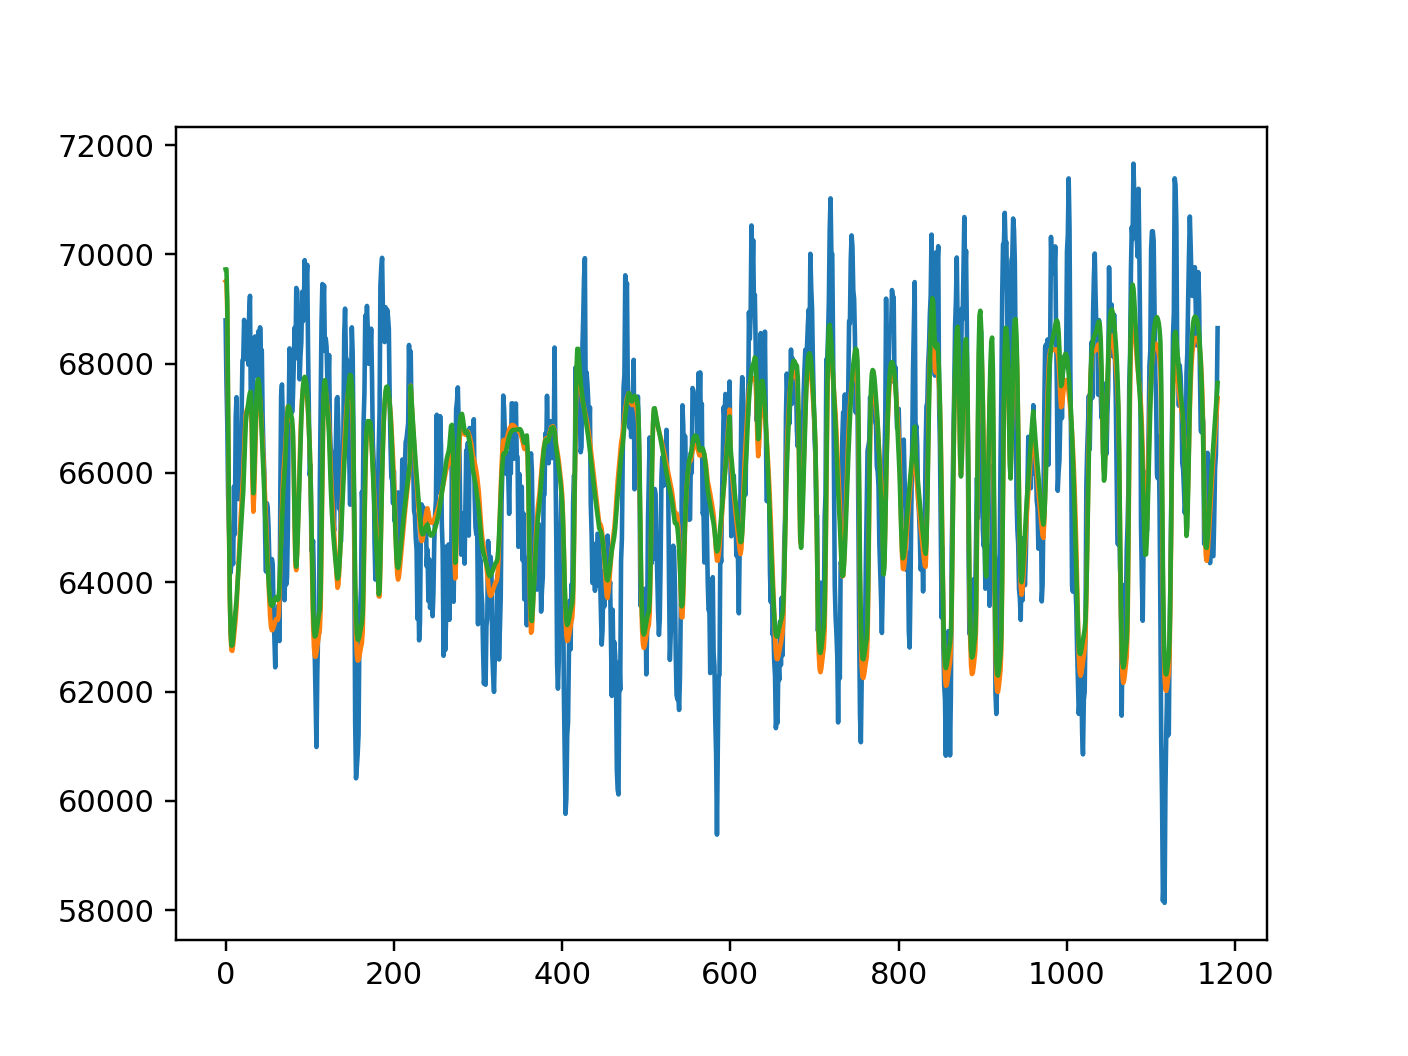

0.500614681357042
0.5146346428172399
[ 1.41190811e+01  2.59130407e+01  1.26994488e+01 -5.78726006e+01
  6.93432891e+04 -5.78726025e+03  1.00000000e+00  1.00000000e+01
  1.00000000e+00  4.97458965e-01]
[ 3.99440154e+01  7.13321233e+01  1.00000000e-01  3.15720950e+02
  6.98449810e+04 -5.79077268e+03  1.47020453e+04  1.51453988e+01
  9.65555142e-01  5.14634643e-01]


In [120]:
%matplotlib notebook
vox_num=50370
fig=pl.figure()
tc_vox=tc_full_iso_nonzerovar_dict['tc'][vox_num]
norm_grid_tc=gg_norm.return_single_prediction(*list(norm_grid[vox_num,:-1]))
norm_iter_tc=gg_norm.return_single_prediction(*list(norm_num[vox_num,:-1]))
redo_tc = gg_norm.return_single_prediction(*list(res_2[:-1]))
#gauss_tc=gg.return_single_prediction(*list(starting_params[212116,:-1]))
pl.plot(tc_vox)
pl.plot(norm_grid_tc)
#pl.plot(norm_iter_tc)
pl.plot(redo_tc) 

print(1-np.sum((tc_vox-norm_grid_tc)**2)/(1180*np.var(tc_vox)))
#print(1-np.sum((tc_vox-norm_iter_tc)**2)/(1180*np.var(tc_vox)))
print(1-np.sum((tc_vox-redo_tc)**2)/(1180*np.var(tc_vox)))

print(norm_grid[vox_num])
#print(norm_num[vox_num])
print(res_2)

In [17]:
print("gauss grid rsq: "+str(gf.gridsearch_params[gf_css.rsq_mask, -1].mean()))
print("gauss iter rsq: "+str(gf.iterative_search_params[gf_css.rsq_mask, -1].mean()))
print("css iter rsq: "+str(gf_css.iterative_search_params[gf_css.rsq_mask, -1].mean()))
print("dog iter rsq: "+str(gf_dog.iterative_search_params[gf_dog.rsq_mask, -1].mean()))
print("norm iter rsq: "+str(gf_norm.iterative_search_params[gf_norm.rsq_mask, -1].mean()))

gauss grid rsq: 0.5283278842418279
gauss iter rsq: 0.5364675907041455
css iter rsq: 0.6016873876717737
dog iter rsq: 0.5420141200397566
norm iter rsq: 0.6036119283624145


<IPython.core.display.Javascript object>


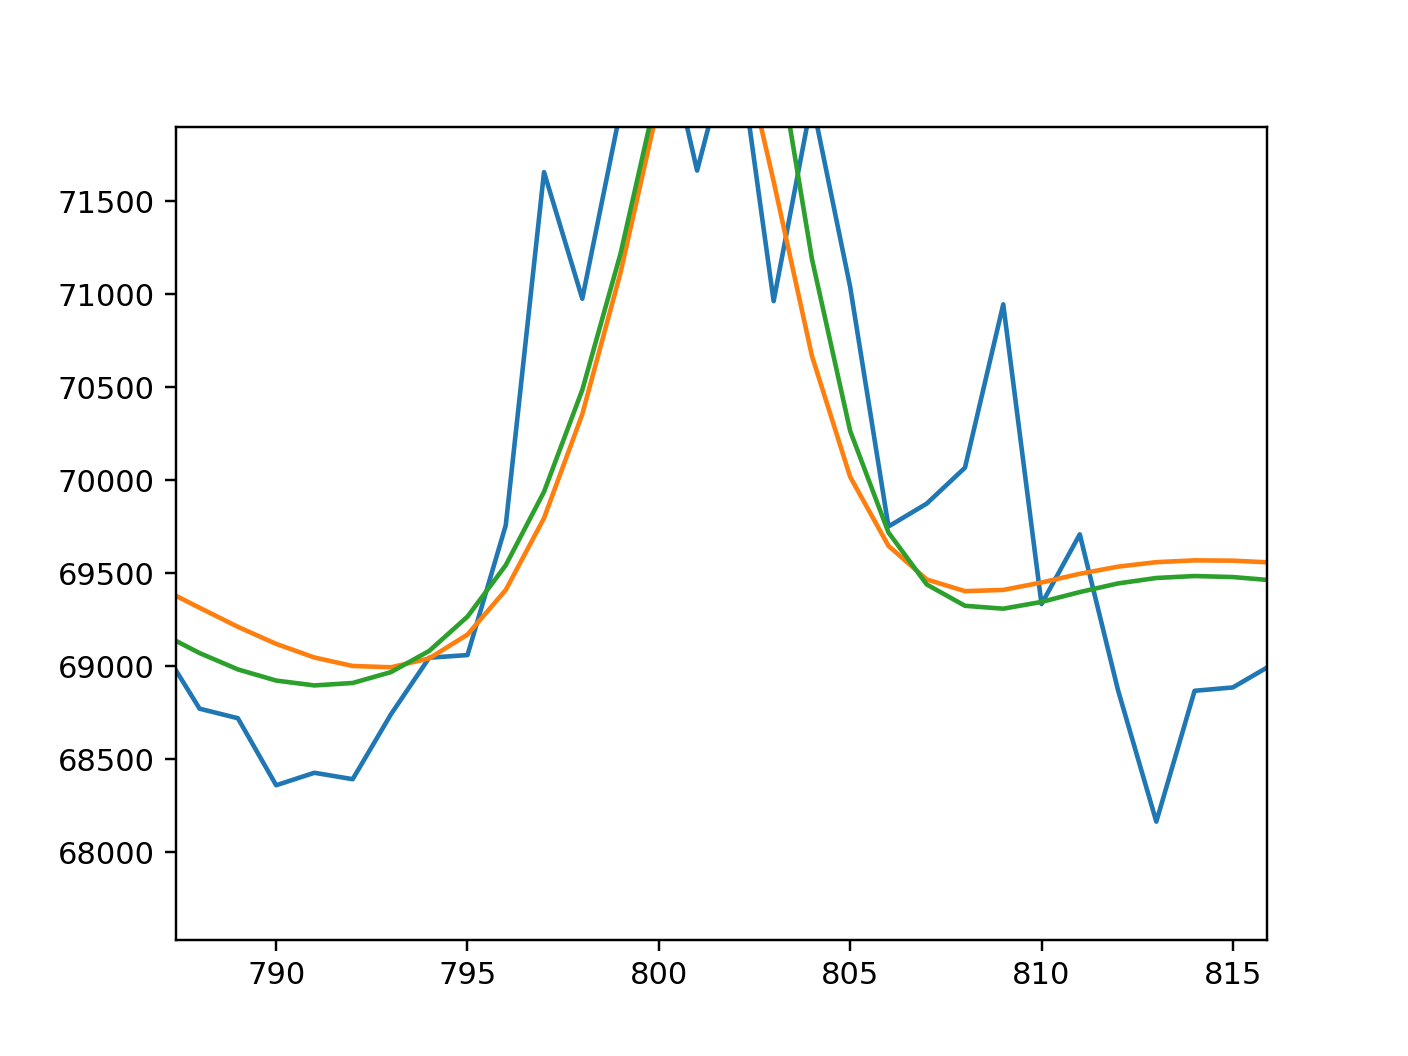

In [163]:
%matplotlib notebook
vox=50370
fig=pl.figure()
pl.plot(tc_full_iso_nonzerovar_dict['tc'][vox])
#pl.plot(gg_norm.return_single_prediction(*list(current_result[np.where(gridsearch_params[:,-1]>0.66),:][0,vox,:-1])))
#pl.plot(gg_norm.return_single_prediction(*list(norm_vox[:-1])))
#pl.plot(gg_dog.return_single_prediction(*list(dog_vox[:-1])))
pl.plot(gg_norm.return_single_prediction(*list(norm_grid[:-1])))
pl.plot(gg_norm.return_single_prediction(*list(res[:-1])))


<IPython.core.display.Javascript object>


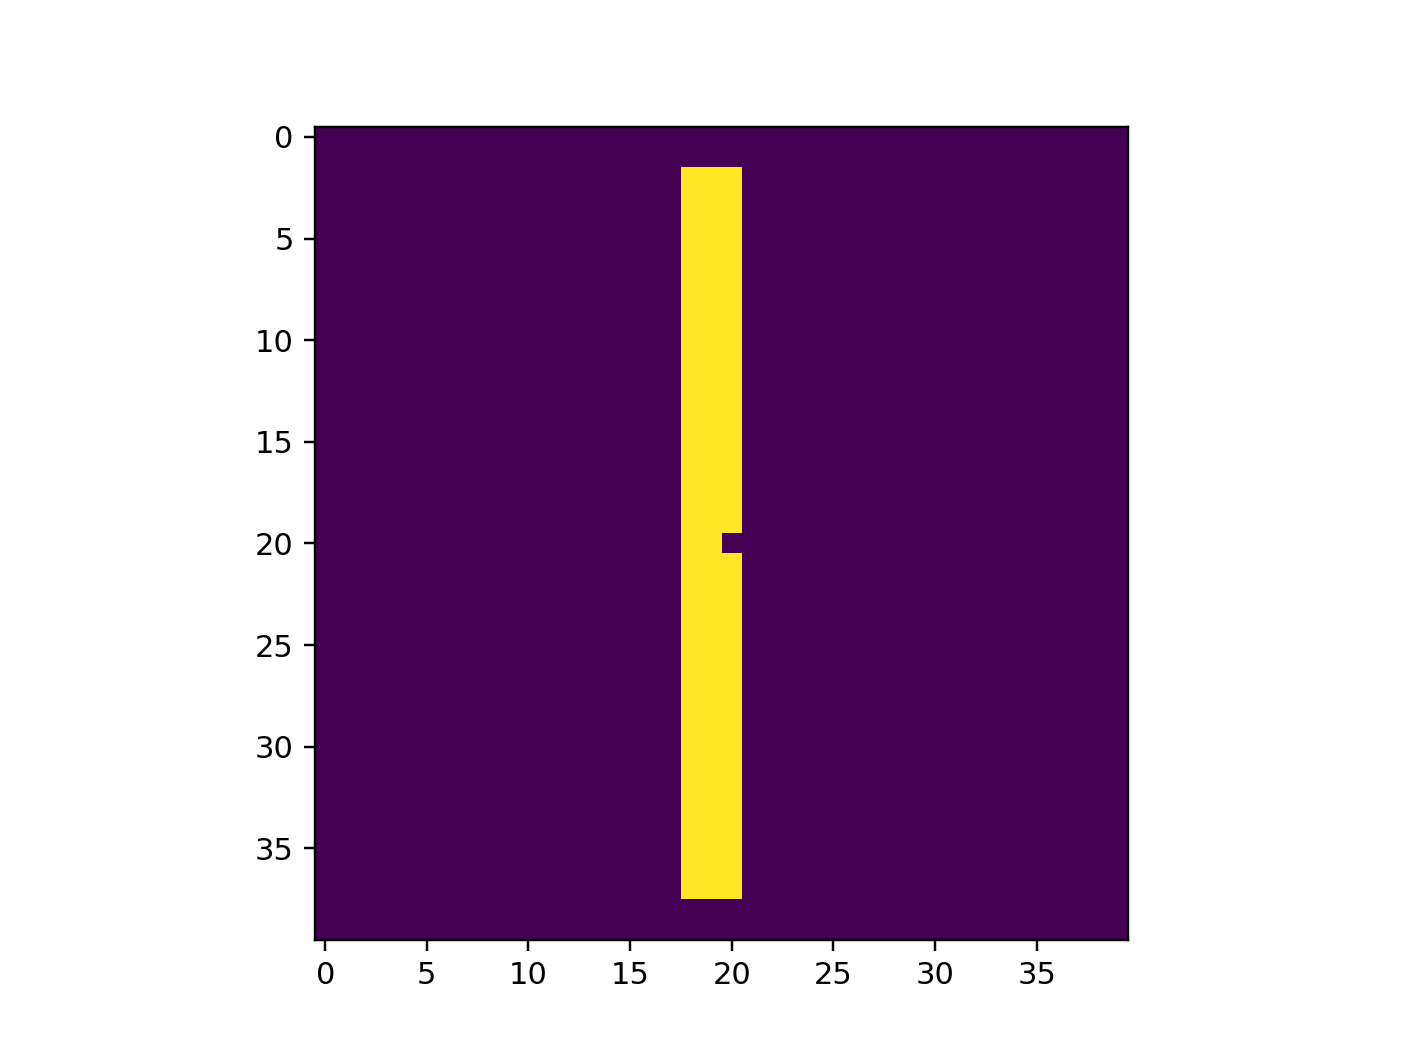

(40, 40, 1180)

In [27]:
%matplotlib notebook
pl.figure()
pl.imshow(prf_stim.design_matrix[:,:,120])
prf_stim.design_matrix.shape

<IPython.core.display.Javascript object>


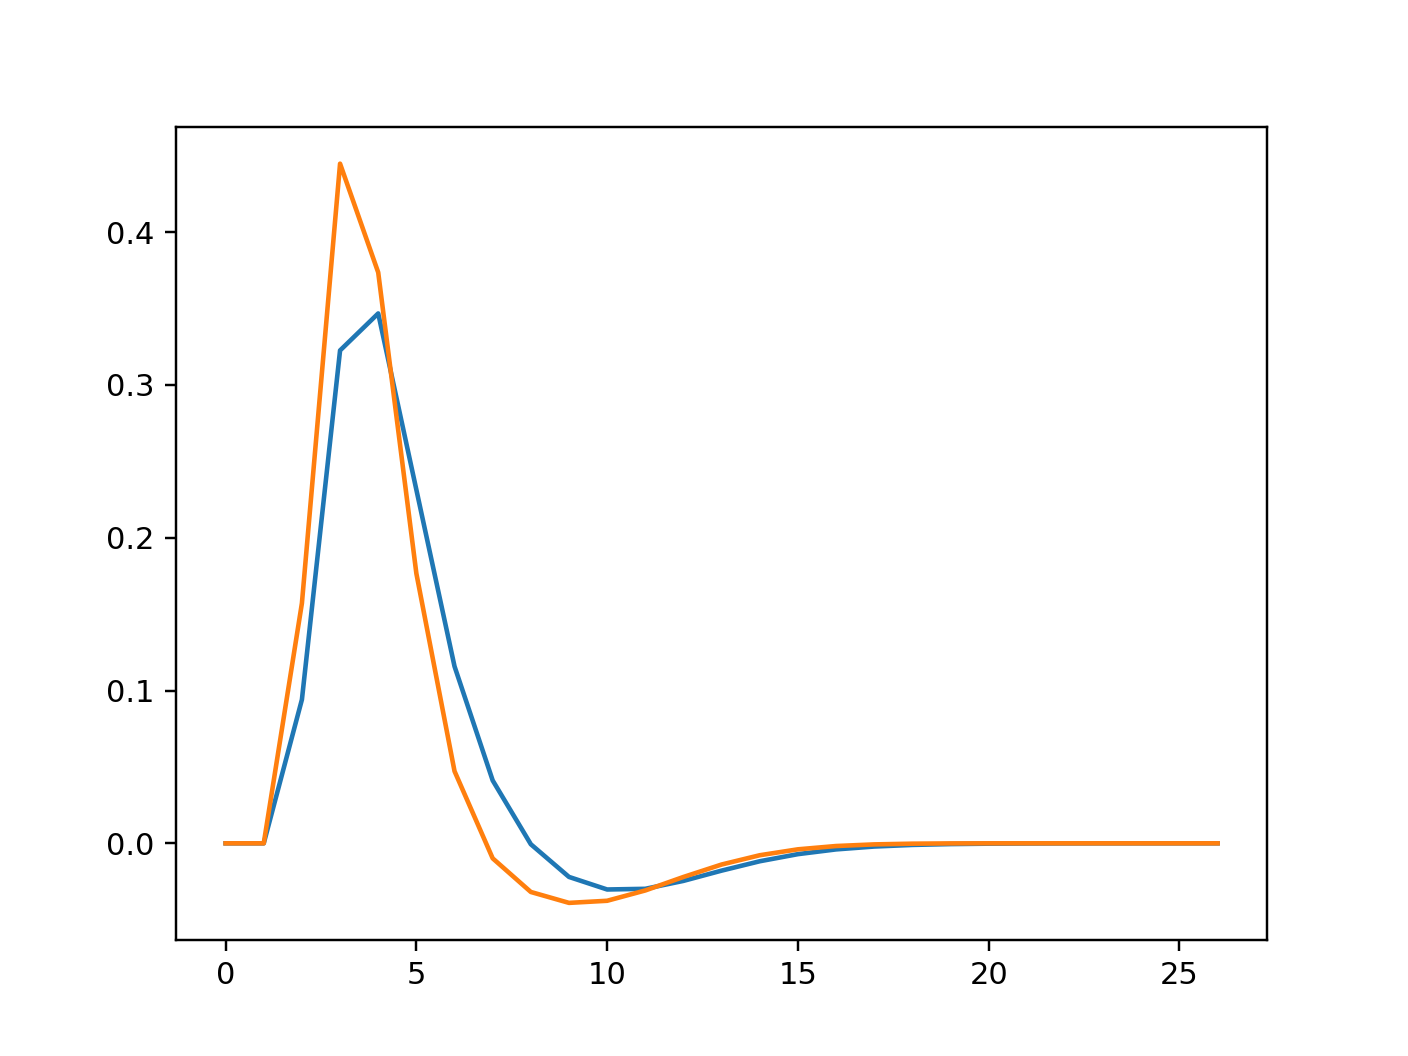

In [176]:
pl.figure()
from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative

hrf=[1,2,0]
hrf = np.array([hrf[0] * spm_hrf(tr=1.5,
                                                  oversampling=1, time_length=40),
                                 hrf[1] * spm_time_derivative(tr=1.5,
                                                              oversampling=1, time_length=40),
                                 hrf[2] * spm_dispersion_derivative(tr=1.5,
                                                                    oversampling=1, time_length=40)]).sum(axis=0)
pl.plot(gg_norm.hrf)
pl.plot(hrf)

In [179]:
#gii stuff
res = np.zeros((tc_full_iso_nonzerovar_dict['orig_data_shape']['L_shape'][0]+
                tc_full_iso_nonzerovar_dict['orig_data_shape']['R_shape'][0],10))

res[tc_full_iso_nonzerovar_dict_check['nonzerovar_mask']] = gf_norm.iterative_search_params

res_L = res[:tc_full_iso_nonzerovar_dict_check['orig_data_shape']['L_shape'][0]]
res_R = res[tc_full_iso_nonzerovar_dict_check['orig_data_shape']['L_shape'][0]:]

res_R.shape
#data in make_webgl is 10 by 320k ORDER LEFT RIGHT

In [212]:
#gii stuff
import nibabel as nb
darrays = [nb.gifti.gifti.GiftiDataArray(d) for d in res_R.T]
gii_in_R = nb.load(opj(data_path, 'fmriprep/'+subj+'/ses-1/func/'+subj+'_ses-1_task-'+task_name+'_run-1_space-'+fitting_space+'_hemi-R.func.gii'))

gii_out = nb.gifti.gifti.GiftiImage(header=gii_in_R.header, 
                            extra=gii_in_R.extra,
                            darrays=darrays)

out_name = '/Users/marcoaqil/PRFMapping/sub-001_norm-iterparams_space-fsaverage_hemi-R-attempt.gii'
nb.save(gii_out, out_name)

In [208]:
#gii stuff
darrays = [nb.gifti.gifti.GiftiDataArray(d) for d in res_R.T]
print(gii_in_R.darrays[0].data.shape)
print(darrays[0].data.shape)

(163842,)
(163842,)


In [7]:
gauss = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-gauss_space-fsaverage.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_gridparams-norm_space-fsaverage.npy") 
norm_an = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_analytic.npy")
norm_num = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_numerical.npy")
dog_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-dog_space-fsaverage.npy")
css_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-css_space-fsaverage.npy")
norm_unbound = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_unbounded.npy")

norm_combined=np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_norm-iterparams-combined_space-fsaverage.npy")
#(norm_num[:,-1]-norm_grid[:,-1]).argmin()


In [46]:

rsq_models = np.zeros((tc_full_iso_nonzerovar_dict['orig_data_shape']['L_shape'][0]+
                tc_full_iso_nonzerovar_dict['orig_data_shape']['R_shape'][0],3))

rsq_models[tc_full_iso_nonzerovar_dict['nonzerovar_mask'],0] = css_res[:, -1]
rsq_models[tc_full_iso_nonzerovar_dict['nonzerovar_mask'],1] = dog_res[:, -1]
rsq_models[tc_full_iso_nonzerovar_dict['nonzerovar_mask'],2] = norm_unbound[:, -1]




red = cortex.Vertex(rsq_models[:, 0], subject='fsaverage', vmin=0.2, vmax=0.8)
green = cortex.Vertex(rsq_models[:, 1], subject='fsaverage', vmin=0.2, vmax=0.8)
blue = cortex.Vertex(rsq_models[:, 2], subject='fsaverage', vmin=0.2, vmax=0.8)
alpha = np.array(rsq_models[:, 2]>0.2).astype('float32')

models_rsq_RGB = cortex.VertexRGB(red, green, blue, subject='fsaverage', alpha=alpha)


models_rsq_diff_normdog = cortex.Vertex(rsq_models[:,2]-rsq_models[:,1], subject='fsaverage')
models_rsq_diff_normcss = cortex.Vertex(rsq_models[:,2]-rsq_models[:,0], subject='fsaverage')
models_rsq_diff_cssdog = cortex.Vertex(rsq_models[:,0]-rsq_models[:,1], subject='fsaverage')

ds = cortex.Dataset(rsq_1=models_rsq_diff_cssdog, rsq_2=models_rsq_diff_normcss) 

cortex.webgl.show(ds,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=False, 
                 with_borders=True, 
                 with_colorbar=True)

#saving static visualization. not yet working
#ds = cortex.Dataset(rsq=models_rsq_vertex_data)  
#cortex.webgl.make_static(outpath='/Users/marcoaqil/PRFMapping/PRFRSQ', data=ds)


Started server on port 62325


<JS: window.viewer>

Stopping server


In [44]:

ecc_models = np.zeros((tc_full_iso_nonzerovar_dict['orig_data_shape']['L_shape'][0]+
                tc_full_iso_nonzerovar_dict['orig_data_shape']['R_shape'][0],3))

ecc_models[tc_full_iso_nonzerovar_dict['nonzerovar_mask'],0] = np.sqrt(css_res[:,0]**2+css_res[:,1]**2)
ecc_models[tc_full_iso_nonzerovar_dict['nonzerovar_mask'],1] = np.sqrt(dog_res[:,0]**2+dog_res[:,1]**2)
ecc_models[tc_full_iso_nonzerovar_dict['nonzerovar_mask'],2] = np.sqrt(norm_unbound[:,0]**2+norm_unbound[:,1]**2)


import cortex

ecc_norm = cortex.Vertex(ecc_models[:,2], subject='fsaverage')

cortex.webgl.show(ecc_norm,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=False, 
                 with_borders=True, 
                 with_colorbar=True)



Started server on port 25790


<JS: window.viewer>

Stopping server


In [47]:
np.save("/Users/marcoaqil/PRFMapping/sub-001_nonzerovar-mask_space-fsaverage.npy", tc_full_iso_nonzerovar_dict['nonzerovar_mask'])

<IPython.core.display.Javascript object>


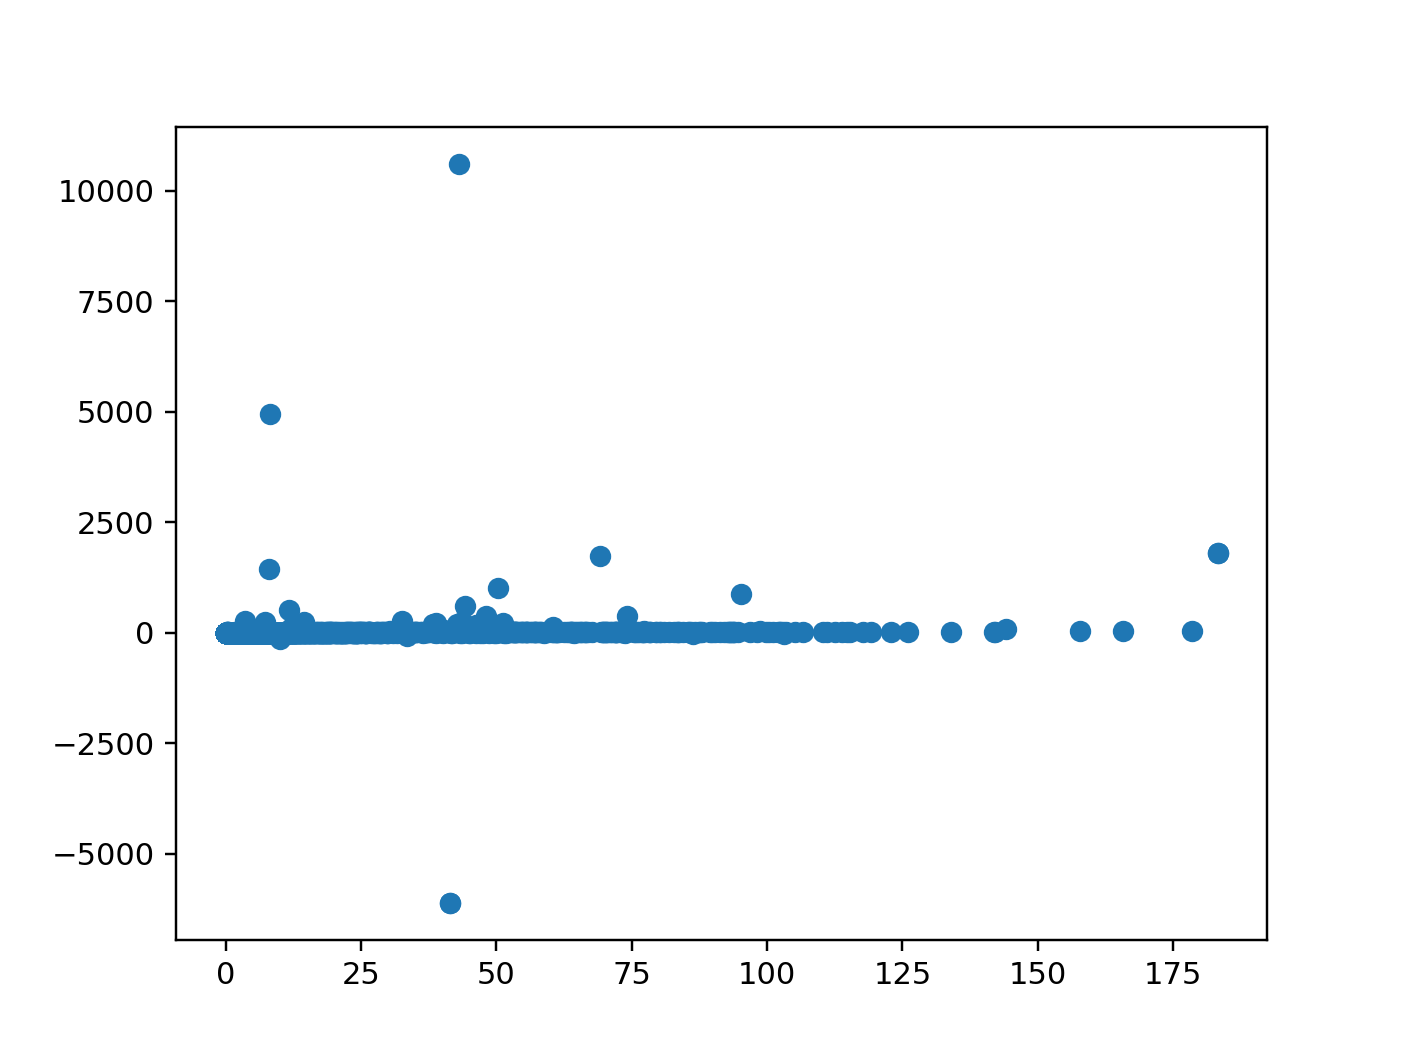

In [39]:
%matplotlib notebook
rsq_map=gauss[:,-1]>0.2
ecc_norm=np.sqrt(norm_unbound[rsq_map,0]**2+norm_unbound[rsq_map,1]**2)
pl.figure()
pl.scatter(ecc_norm, norm_unbound[rsq_map,2])

#ecc size relationship
#pl.scatter(np.sqrt(gauss[rsq_map,0]**2+gauss[rsq_map,1]**2), gauss[rsq_map,-1])
#pl.scatter(np.sqrt(css_res[rsq_map,0]**2+css_res[rsq_map,1]**2), css_res[rsq_map,2])